<a href="https://colab.research.google.com/github/KelvinLam05/credit_card_fraud_detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

The challenge is to recognize fraudulent credit card transactions so that the customers of credit card companies are not charged for items that they did not purchase.

**Load the packages**

In [ ]:
# Importing library
import pandas as pd

**Load the data**

For this project I’ve used the [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) dataset from Kaggle. This anonymised dataset contains transactions made by credit cards in September 2013 by European cardholders.

In [ ]:
# Load dataset
df = pd.read_csv('/content/credit_card_fraud.csv')

In [ ]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [ ]:
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [ ]:
# Examine the data
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

**Examine the class imbalance**

To examine the class imbalance of a data set you can use the Pandas value_counts( ) function on the target column of the dataframe, which is called class on this data set. As you can see, we have 284,315 non-fraudulent transactions in class 0 and 492 fraudulent transactions in class 1. This will represent a massive challenge for most models, since they will favour the dominant class and predict that the very vast majority of orders are non-fraudulent.

In [ ]:
df['class'].value_counts()

0    284315
1       492
Name: class, dtype: int64

By grouping by the class column and then creating an agg( ) we can calculate the costs of fraud. The data set is based on a two day period, in which there were 492 fraudulent transactions potentially generating £60,127.97 in lost revenue. Using a naiive extrapolation, as we don’t have the full data set, this is equivalent to £30,063.98 per day. Therefore, we’re looking at annual fraud costs of around £10,973,354.

In [ ]:
df.groupby('class').agg(transactions = ('class', 'count'), total_revenue = ('amount', 'sum')).round(2)

,transactions,total_revenue
class,,
0,284315,25102462.04
1,492,60127.97


**Split the data**

In [ ]:
X = df.drop('class', axis = 1)

In [ ]:
y = df['class']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

In [ ]:
train_df = X_train.join(y_train)

In [ ]:
test_df = X_test.join(y_test)

**Neural network**

We will be using the powerful FastAI library which is built on top of PyTorch here to fit a neural network to our data. To do so, we would have to preprocess our data and create dataloaders to feed the data into the neural network.

**The dataloaders**

Now let's build our TabularPandas for classifying. We're also going to want to split our data and declare our y_names too:

In [ ]:
from fastai.tabular.all import *

In [ ]:
splits = RandomSplitter(seed = 42)(range_of(train_df))

We'll use all our cat and cont names, the procs, declare a y_name, and finally specify a single-label classification problem with CategoryBlock.

In [ ]:
cont_names, cat_names = cont_cat_split(train_df, dep_var = 'class')
procs = [FillMissing, Categorify, Normalize]
y_names = 'class'
y_block = CategoryBlock()

Now that we have everything declared, let's build our TabularPandas:

In [ ]:
# Define TabularPandas object
to = TabularPandas(df, procs = procs, cat_names = cat_names, cont_names = cont_names, y_names = y_names, splits = splits, y_block = y_block)

In [ ]:
df[y_names] = df[y_names].astype('category')

And now we can build the DataLoaders.

In [ ]:
dls = to.dataloaders(bs = 1024)

And show a batch of data:

In [ ]:
dls.show_batch()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,127148.000000,2.187948,-0.787997,-1.168082,-0.805343,-0.136344,0.431473,-0.757733,0.114592,-0.362838,0.962553,-0.319027,0.388111,0.229752,0.066054,-0.644824,-0.843359,-0.702526,1.289779,0.200440,-0.563034,-0.898475,-2.081439,0.509445,-0.438340,-0.649181,0.069269,-0.040561,-0.058956,1.300003,0
1,112627.000000,2.066954,-1.026004,-1.485849,-1.008858,-0.543455,-0.846961,-0.405816,-0.234733,-0.654248,1.028197,0.631216,-0.338754,-0.319858,0.293845,-0.245219,1.261708,-0.229059,-0.559362,0.816746,0.103424,0.510846,1.277314,-0.131007,-0.354767,0.167285,0.074189,-0.056960,-0.067167,85.849998,0
2,132106.000000,2.000884,-0.207863,-0.765490,0.590913,-0.369543,-0.890470,-0.121794,-0.205423,0.778068,0.082856,-0.806540,0.323711,-0.027968,0.143700,0.311229,0.022528,-0.357533,-0.477134,-0.211184,-0.213401,-0.024742,0.074427,0.222003,0.005941,-0.222376,0.228743,-0.038421,-0.052367,14.949997,0
3,35627.003906,-1.423092,0.301318,1.306288,-1.495750,0.543258,-0.240477,0.659296,-0.261477,0.751233,0.776895,1.418473,0.446671,-0.146911,-0.527312,0.265199,0.475942,-1.048065,-0.319267,-0.678510,0.029519,-0.304615,-0.028347,0.297910,-0.273507,-0.168587,0.711468,-0.064392,-0.298739,7.680000,0
4,130626.000000,-0.848309,2.036294,-0.514868,0.793596,0.947615,-0.942526,0.933300,0.194335,-0.888198,-1.391948,0.001596,-0.160022,0.001576,-1.688312,0.391551,0.429482,1.679141,0.522060,-0.417385,-0.178865,-0.171933,-0.706292,-0.000750,0.830699,-0.314045,-0.957294,-0.192974,0.154074,7.500000,0
5,74639.000000,0.830764,-0.283697,0.489422,1.570227,-0.570017,0.267641,-0.329793,0.285899,0.617696,-0.595760,1.375441,0.912005,-0.812225,-1.102120,-0.844420,-0.161789,1.029869,0.264510,-0.326982,0.055639,0.054553,0.177866,-0.187114,0.147692,0.485415,-0.287111,0.059158,0.059476,126.540001,0
6,24215.000000,-0.372674,0.420728,2.645620,0.259254,-0.255019,0.678670,-0.068065,0.179656,1.616836,-0.706266,1.932383,-2.104641,0.724762,1.090108,-1.088622,-0.115311,0.544273,0.323876,-0.138717,-0.075128,-0.142066,0.126127,-0.112268,-0.034224,-0.385985,0.223578,-0.114847,-0.177288,11.500000,0
7,74656.000000,1.327500,-1.198182,0.213473,-1.734595,-0.529067,1.510847,-1.372949,0.524644,-2.081903,1.425985,1.867472,0.014814,0.277806,0.011601,0.991286,-1.371674,1.349894,-1.371784,-1.379697,-0.466984,-0.070458,0.319891,0.117268,-1.371351,0.084933,-0.073520,0.097858,-0.008872,6.000000,0
8,68551.000000,-0.751220,0.893167,2.158621,0.234005,0.270848,-0.444137,1.056523,-1.566908,0.689524,0.116981,-0.534112,0.154894,-0.316811,-0.934247,-1.040776,-0.666235,-0.391080,-0.490589,-0.643098,-0.228145,0.705140,0.233904,-0.239872,0.713543,-0.078437,-0.616601,-0.553230,-0.526805,14.900002,0
9,43410.000000,1.019694,0.127590,0.458570,1.325886,-0.311837,-0.553377,0.218094,-0.149310,-0.171315,-0.038402,0.234461,0.797097,0.787460,0.231785,1.084905,-0.266636,-0.119287,-0.709585,-0.986623,0.024164,0.175384,0.454393,-0.117186,0.430102,0.556289,-0.281896,0.026004,0.037023,81.169998,0


**Tabular Learner and training a model**


Now we can build our Learner! 

In [ ]:
learn = tabular_learner(dls, layers = [800, 400], loss_func = CrossEntropyLossFlat(), metrics = [Precision(), Recall(), FBeta(beta = 1), RocAucBinary()])

And now we can fit!

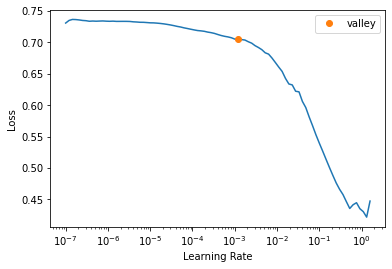

In [ ]:
lr = learn.lr_find()

In [ ]:
callbacks = [EarlyStoppingCallback(patience = 5), SaveModelCallback()]

In [ ]:
# Train the model with early stop and save model callbacks
learn.fit_one_cycle(100, lr_max = lr.valley, cbs = callbacks)

epoch,train_loss,valid_loss,precision_score,recall_score,fbeta_score,roc_auc_score,time
0,0.624674,0.597164,0.020956,0.876543,0.040934,0.914107,00:12
1,0.541134,0.505938,0.083032,0.851852,0.151316,0.909640,00:12
2,0.415640,0.377216,0.289256,0.864198,0.433437,0.932745,00:12
3,0.254199,0.239592,0.752809,0.827160,0.788235,0.936352,00:12
4,0.118871,0.081929,0.773810,0.802469,0.787879,0.888445,00:12
5,0.036872,0.022652,0.815789,0.765432,0.789809,0.905010,00:12
6,0.017848,0.012705,0.853333,0.790123,0.820513,0.896383,00:12
7,0.007791,0.006992,0.835443,0.814815,0.825000,0.922001,00:11
8,0.007417,0.021120,0.769231,0.864198,0.813953,0.945996,00:11
9,0.006057,0.011885,0.795181,0.814815,0.804878,0.891214,00:17


Better model found at epoch 0 with valid_loss value: 0.5971642732620239.
Better model found at epoch 1 with valid_loss value: 0.5059383511543274.
Better model found at epoch 2 with valid_loss value: 0.37721574306488037.
Better model found at epoch 3 with valid_loss value: 0.23959216475486755.
Better model found at epoch 4 with valid_loss value: 0.08192850649356842.
Better model found at epoch 5 with valid_loss value: 0.022652270272374153.
Better model found at epoch 6 with valid_loss value: 0.012705203145742416.
Better model found at epoch 7 with valid_loss value: 0.0069921426475048065.
No improvement since epoch 7: early stopping


Considering the fact that is dataset is highly imbalanced, a precision of 0.84 and recall of 0.81 is actually very impressive, this gives an F1 score of 0.83 and a ROC AUC score of 0.92.

In [ ]:
learn.validate()

(#5) [0.0069921426475048065,0.8354430379746836,0.8148148148148148,0.825,0.9220014079739478]

**Assess the performance of the model**

There are a few ways we can assess the performance of a neural network model. I’ve gone with a few of the most commonly used metrics: ROC/AUC, and the F1 score. 

In [ ]:
test_df.drop(['class'], axis = 1, inplace = True)
dl = learn.dls.test_dl(test_df)

In [ ]:
preds = learn.get_preds(dl = dl)

In [ ]:
y_pred = np.argmax(preds[0], axis = 1).numpy()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_pred, y_test)

0.916502538130576

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_pred, y_test)

0.8219178082191781

To examine how well the model performed in a little more detail we can make use of the classification_report( ) and confusion_matrix( ) functions. The classification report shows us the precision, recall, and F1 score for our predictions.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.81      0.82       148

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



The confusion matrix (possibly so-named because everyone finds it so confusing to interpret) shows us that:

* 39778 true negatives (the customers didn’t commit fraud, and we predicted this correctly)

* 66 true positives (the customers did commit fraud, and we predicted this correctly)

* 13 false positives (the customers didn’t commit fraud, but we wrongly predicted that they would)

* 15 false negatives (the customers did commit fraud, but we wrongly predicted that they wouldn’t)

Out of 39872 predictions, we got it right 39844 times, and we got it wrong just 28 times.



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

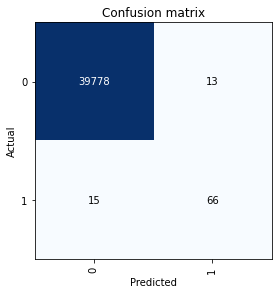

In [ ]:
interp.plot_confusion_matrix()

**Exporting TabularPandas**

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

In [ ]:
learn.export()